In [73]:
import pandas as pd
import numpy as np
import random as rand

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from pmdarima import auto_arima #!pip install pmdarima
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from scipy import stats as sps
from scipy.interpolate import interp1d
import scipy.stats

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

from IPython.display import clear_output

from datetime import timedelta
from time import time

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   :  8}

mpl.rc('font', **font)

mpl.rcParams['axes.grid']=True
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

mpl.rcParams['axes.grid']=True
pd.options.display.max_rows = 999


In [74]:
########################################################## Import Data #########################################################
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


def prepare(df, name):
    cols_to_melt = df.columns.values[4:]
    res = pd.melt(df, id_vars='Country/Region', var_name='date', value_vars=cols_to_melt, value_name=name)
    res['date'] = pd.to_datetime(res['date'])
    res = res.sort_values(by = ['Country/Region', 'date'])
    res = res.set_index('date')
    res.columns = ['country', name]
    return res

confirmed_df = prepare(confirmed_df, 'Confirmed Cases')
recovered_df = prepare(recovered_df, 'Recovered Cases')
death_df = prepare(death_df, 'Death Cases')


In [17]:
############################################################ Plot ##############################################################
############################################################ Plot - LSTM ########################################################
def plot2series(df, split, col = 'Confirmed Cases', title = ' ', save_name = 'img'):
    df1 = df.iloc[0:split, :]
    df2 = df.iloc[split - 1:,:]
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    
    plt.plot(df1[col], color = 'red', linewidth=2, markersize=6, label = 'Actual Data')
    plt.plot(df2[col], color = 'green', linewidth=2, markersize=6, label = 'Predicted Data')

    ci = 1.96 * df2[col].std()/df2[col].mean()

    plt.fill_between(df2.index.get_level_values('date'), 
                    (df2[col].values-(df2[col].values * ci)), 
                    (df2[col].values+(df2[col].values * ci)), 
                    color='b', alpha=.1, label = 'Confidence interval 95%')

    # plt.plot(df1[col], color = 'red', marker='o', linewidth=2, markersize=6, label = 'Actual Data')
    # plt.plot(df2[col], color = 'green', marker='o', linewidth=2, markersize=6, label = 'Predicted Data')

    x_ticks = np.linspace(df1.index.min().value, df2.index.max().value, 5)
    x_ticks = pd.to_datetime(x_ticks)
    plt.xticks(x_ticks, rotation = 0)
    y_ticks = np.linspace(df1[col].min(), df2[col].max() + (df2[col].max()*0.45), 10) # modifier here
    plt.yticks(y_ticks)
    
    plt.legend(loc='best')
    # plt.title(title)
    # ax.grid(True)
    plt.show()

In [18]:
######################################### Plot Rt ##################################################
def plot_rt(result, ax, state_name):
    # ax.set_title(f"{state_name}")
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    '''Edit'''
    extended = pd.date_range(start=pd.Timestamp('2020-08-07'),
                             end=index[-1]+pd.Timedelta(days=1))
    '''Edit'''
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)

    '''Edit'''
    ax.set_xlim(pd.Timestamp('2020-08-07'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    '''Edit'''

    fig.set_facecolor('w')

In [27]:
####################################################### ARIMA - LSTM functions ####################################################
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def mean_absolute_percentage_error(actual, prediction):
    return 100 * np.mean(np.abs((actual - prediction))/actual)

def get_best_arima(data, train_rate = 0.8):
    # prepare train and test data
    train_size = int(len(data) * train_rate)
    test_size = data.size - train_size 
    data = data.reset_index(drop=True)
    train = data.head(train_size).values.tolist()
    test = data.tail(test_size).values.tolist()

    # Initialize model
    model = auto_arima(train, max_p=3, max_q=3, seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

    # Determine model parameters
    model.fit(train)
    order = model.get_params()['order']
    # print('ARIMA order:', order, '\n')
    print(model.summary())
    # Genereate predictions
    prediction = []
    for i in range(len(test)):
        model = pm.ARIMA(order=order)
        model.fit(train)
        # print('working on', i+1, 'of', test_size, '-- ' + str(int(100 * (i + 1) / test_size)) + '% complete')
        prediction.append(model.predict()[0])
        train.append(test[i])

    # Generate error data
    mse = mean_squared_error(test, prediction)
    rmse = mse ** 0.5
    msle = mean_squared_log_error(np.array(test), np.array(prediction))
    rmsle = np.sqrt(msle)
    mae = mean_absolute_error(np.array(test), np.array(prediction))
    mape = mean_absolute_percentage_error(np.array(test), np.array(prediction))
    return prediction, order, mse, rmse, msle, rmsle, mae, mape

def show_arima(data, train_rate = 0.8, show_plots = False, days_num = 90, Category = 'Confirmed Cases'):
    res_arima_test, best_order, mse, rmse, msle, rmsle, mae, mape= get_best_arima(data, train_rate)
    print('>>> ', Category, ' ARIMA Best Order : ', best_order, 'MSE = %.5f RMSE = %.5f MSLE = %.5f RMSLE = %.5f MAE = %.5f MAPE = %.5f' % (mse, rmse, msle, rmsle, mae, mape))
    model_cc = ARIMA(data[Category], order = best_order, freq = 'D')
    fitted_model_cc = model_cc.fit()
    residuals_cc = pd.DataFrame(fitted_model_cc.resid)

    if show_plots:
        fig, ax = plt.subplots()
        ax = data.loc['2020-01-22':].plot(ax=ax)
        plot_predict(fitted_model_cc,'2021-11-23','2022-03-22',ax=ax)
        #fitted_model_cc.plot_predict(best_order[1], len(data) + days_num)
        residuals_cc.plot(title= Category + ' Residuals', legend=None)
        residuals_cc.plot(kind='kde', title= Category + ' Density', legend=None)
        plt.show()

    data = data.reset_index(drop=True)
    train = data.head(len(data)).values.tolist()
    res_ConfirmedCases = []
    model = pm.ARIMA(order=best_order)
    model.fit(train)
    res_ConfirmedCases = model.predict(n_periods=days_num)
        
    return res_ConfirmedCases

def prepare_arima_newCases(df, days_num, date):
    df = df + np.random.randint(low = -5000, high = 5000, size = len(df))
    NewCases_arima_df = pd.DataFrame({'target':df})

    date_idx = pd.date_range(date, periods=len(df), freq='D')
    idx = pd.DatetimeIndex(date_idx)
    NewCases_arima_df['date'] = idx
    NewCases_arima_df = NewCases_arima_df.set_index(['date'])

    NewCases_arima_df = NewCases_arima_df[NewCases_arima_df['target']!=0]
    NewCases_arima_df = NewCases_arima_df['target'].astype('float64')
    morocco = pd.Series(dtype='float64')
    morocco = NewCases_arima_df
    return morocco

def evaluate_lstm(data, train_rate = 0.8, lstm_len=4, Category = 'Confirmed Cases'):
    # prepare train and test data
    train_size = int(len(data) * train_rate)
    test_size = data.size - train_size
    val = data.iloc[-test_size:,:] 
    data = data.reset_index(drop=True)
    test = data.tail(test_size).values.tolist()
    dataset = np.reshape(data.values, (len(data), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)
    x_train = []
    y_train = []
    x_test = []

    for i in range(lstm_len, train_size):
        x_train.append(dataset_scaled[i - lstm_len:i, 0])
        y_train.append(dataset_scaled[i, 0])
    for i in range(train_size, len(dataset_scaled)):
        x_test.append(dataset_scaled[i - lstm_len:i, 0])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Set up & fit LSTM RNN
    model = Sequential()
    model.add(LSTM(lstm_len, input_shape=(x_train.shape[1], 1)))
    model.add(Dense(lstm_len, activation="relu"))
    model.add(Dense(int(lstm_len/2), activation="relu"))
    model.add(Dense(1))
    # Compile the model
    model.compile(loss=tf.keras.losses.mse, optimizer='adagrad', metrics=["mse"])
    early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=5)
    history = model.fit(x_train, y_train, epochs=20, batch_size=8, verbose=0, callbacks=[early_stopping])
    # Show train loss results 
    print(model.summary())
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("Losses during training")
    plt.legend()
    plt.show()

    # Generate predictions
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction).tolist()

    output = []
    for i in range(len(prediction)):
        output.extend(prediction[i])
    prediction = output
    # Fitting Results 
    
    plt.plot(val[Category], label='Real Data')
    plt.plot(val.index, prediction, label='LSTM test')
    x_ticks = np.linspace(val.index.min().value, val.index.max().value, 5)
    x_ticks = pd.to_datetime(x_ticks)
    plt.xticks(x_ticks, rotation = 0)
    y_ticks = np.linspace(0, val[Category].max(), 10)
    plt.yticks(y_ticks)
    plt.legend(loc='best')
    plt.show()
    # Generate error data
    mse = mean_squared_error(data.tail(len(prediction)).values, prediction)
    rmse = mse ** 0.5
    msle = mean_squared_log_error(data.tail(len(prediction)).values, prediction)
    rmsle = np.sqrt(msle)
    mae = mean_absolute_error(data.tail(len(prediction)).values, prediction)
    mape = mean_absolute_percentage_error(np.array(data.tail(len(prediction)).values), np.array(prediction))
    return prediction, mse, rmse, msle, rmsle, mae, mape

def series_to_supervised(df, n_in=1, n_out=1, Category = 'Confirmed Cases' , dropnan=True):
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
	    cols.append(df.shift(i))
	    names += [Category+'(t-%d)' % i]
    for i in range(0, n_out):
	    cols.append(df.shift(-i))
	    if i == 0:
		    names += [Category]
	    else:
		    names += [Category+'(t-%d)' % i]
	    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
	    agg.dropna(inplace=True)
    return agg

def normalize(df, Category = 'Confirmed Cases'):
    ndf = df.copy()
    min_target = ndf[Category].min()
    max_target = ndf[Category].max()
    ndf[Category]  = (ndf[Category] - min_target) / (max_target - min_target)
    return (ndf, min_target, max_target)

def denomalize(df, min_target, max_target, Category = 'Confirmed Cases'):
    ddf = df.copy()
    ddf[Category] = ddf[Category] * (max_target - min_target) + min_target 
    return ddf

def denomalize_value(value, min_target, max_target):
    return value * (max_target - min_target) + min_target

def show_lstm(df, train_rate = 0.8, lstm_len=4, days_num = 90, Category = 'Confirmed Cases'):
    forcast = df.copy()
    train_size = int(len(forcast) * train_rate)
    for itr in range(days_num):
        ## Encode data
        ndf, min_target, max_target = normalize(forcast, Category)
        reframed = series_to_supervised(ndf, train_size, 1, Category, True)
        train = reframed.values
        train_X, train_y = train[:, :-1], train[:, -1]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        tf.keras.backend.clear_session()
        input_shape=(train_X.shape[1], train_X.shape[2])

        # Set up & fit LSTM RNN
        model = Sequential()
        model.add(LSTM(lstm_len, input_shape=input_shape))
        model.add(Dense(lstm_len, activation="relu"))
        model.add(Dense(int(lstm_len/2), activation="relu"))
        model.add(Dense(1))

        model.compile(loss=tf.keras.losses.mse,
                    optimizer='adagrad',
                    metrics=["mse"])
        ## fitting results
        model.fit(train_X, train_y, epochs=20, batch_size=8, verbose=0)
        ## predict new values 
        yhat = model.predict(train_X)[-1, 0]
        yhat = denomalize_value(yhat, min_target, max_target)
        last_date = forcast.iloc[[-1]].index
        last_date = last_date + timedelta(days=1)
#        print('In', last_date.values, 'Cases:', yhat )
        #forcast = forcast.append(pd.DataFrame(yhat, index=last_date, columns = [Category]))
        forcast = pd.concat([forcast,pd.DataFrame(yhat, index=last_date, columns = [Category])])
    return forcast

def prepare_lstm_newCases(df, split):
    test = df.copy()
    # for i in range(0,len(test)):
    #     if(i == 0):
    #         n = 0
    #     else:
    #         n = df[df.columns.values[0]][i-1]
    #     v = test[df.columns.values[0]][i] - n
    #     if(v > 0):
    #         test[df.columns.values[0]][i] = v
    #     else:
    #         test[df.columns.values[0]][i] = rand.uniform(200,300)
    NewCases_df = test.iloc[split -1:,:]
    NewCases_df = NewCases_df[df.columns.values[0]].astype('float64')
    return NewCases_df
####################################################### R effective functions ####################################################
def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(10,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

def highest_density_interval(pmf, p=.95):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
    if best:        
      low = pmf.index[best[0]]
      high = pmf.index[best[1]]
    else:
      low = pmf.index[0]
      high = pmf.index[1]

    return pd.Series([low, high], index=['Low', 'High'])

In [20]:
#########################################################" Simulations "###############################################################
#########################################################"Parameters"##################################################################
days_num = 60 #Number of days to forecast (90 days = 3 months)
train_rate = 0.8 # Learning Rate 0.8
lstm_size = 64 # Number of LSTM Nodes
# Column vector of k
k = np.arange(0, 70)[:, None]
# Different values of Lambda
lambdas = [10, 20, 30, 40]
# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)
k = np.array([20, 40, 55, 90])
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/4
# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))
# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=9666.678, Time=1.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9788.948, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9788.953, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9785.577, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9786.960, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=9681.473, Time=0.90 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9677.746, Time=0.49 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=9651.603, Time=1.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=9676.807, Time=0.64 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=9588.079, Time=1.14 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=9557.492, Time=1.32 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=9616.896, Time=1.13 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=9554.056, Time=1.12 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=9614.909, Time=0.90 sec
 ARIMA(2,2,2)(0,0,0)[0]          

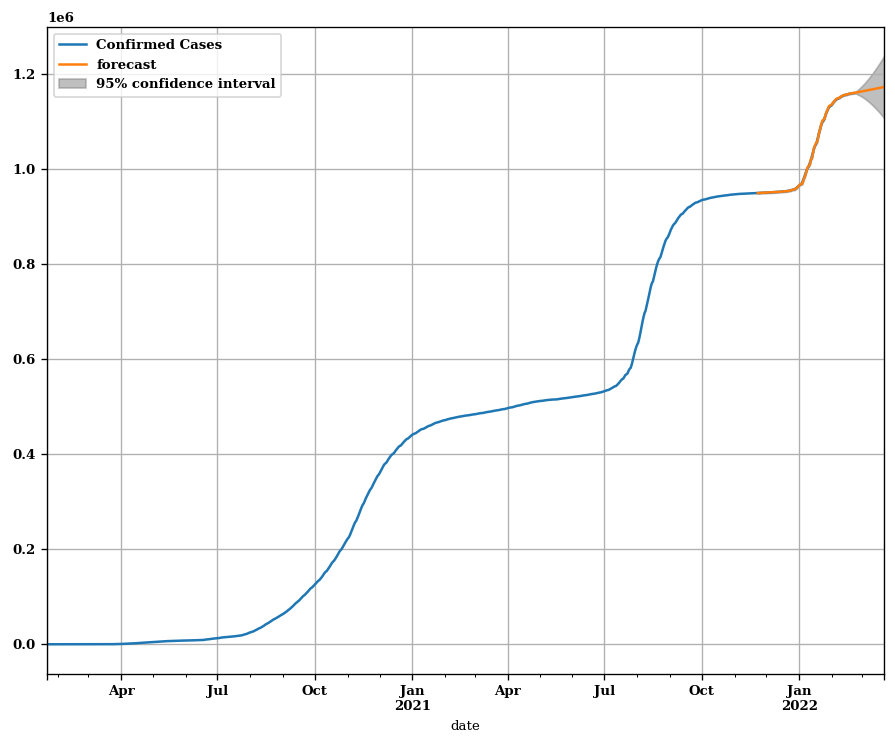

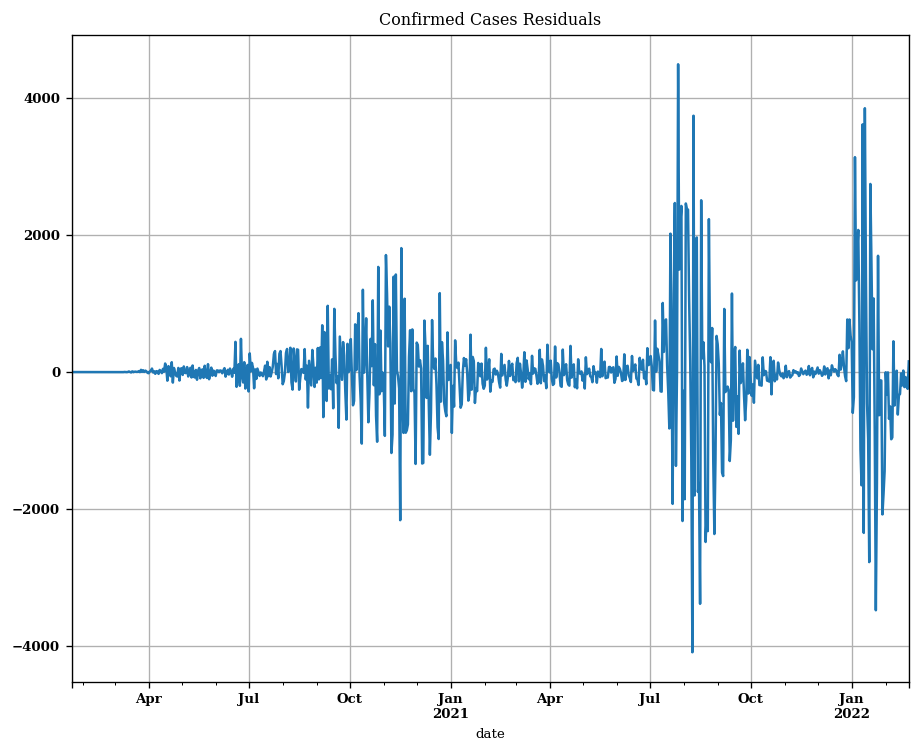

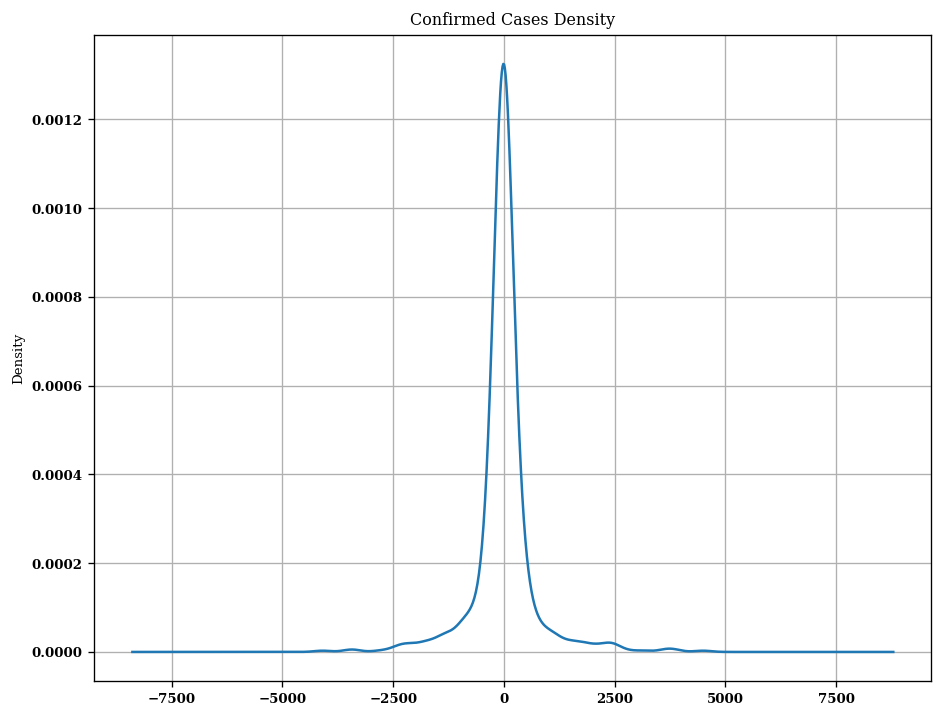

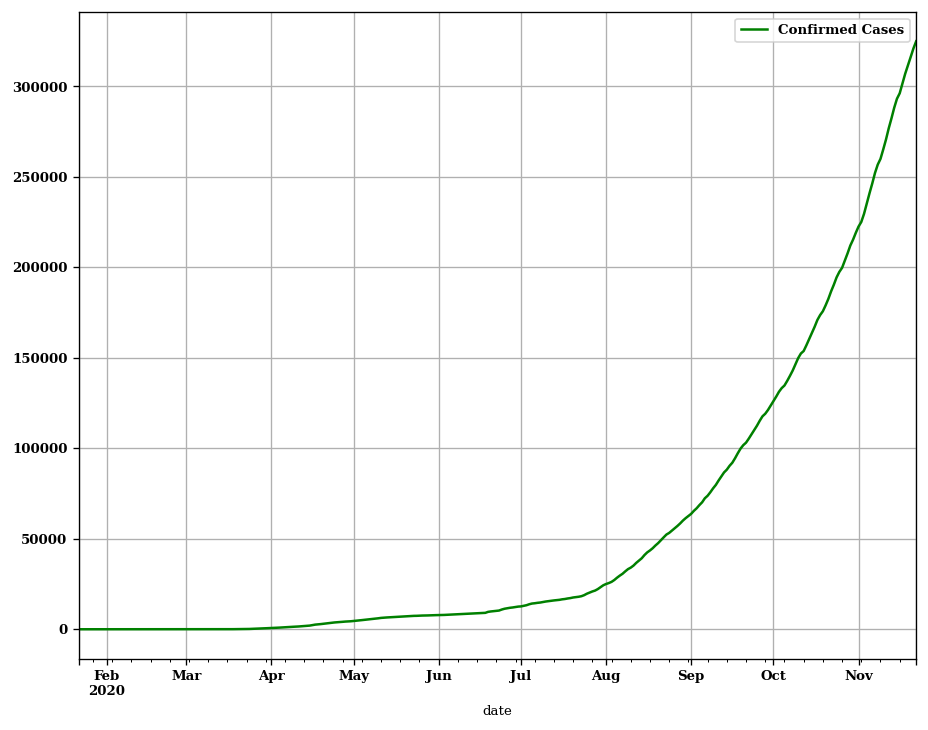

In [40]:
######################################################### ARIMA #######################################################################
# Forecasting Confirmed, Recovered and Death Cases in Morocco
country =  'Morocco'  ## you can use any other country name For Example : Brazil, Italy, Spain
# # Confirmed Cases
country_df = confirmed_df[confirmed_df['country'] == country] ## Choose the right columns for the choosing country
country_df = country_df.drop(columns=['country']) ## Drop the columns name, keeping only data
country_df = country_df[:'2022-02-22']
forcast_ConfirmedCases = country_df.copy() ## Copy the data in forcast variable
# # Show ARIMA Confirmed Cases Results 
res_arima_ConfirmedCases = show_arima(forcast_ConfirmedCases, train_rate, True, days_num,forcast_ConfirmedCases.columns.values[0])

# # Death Cases 
# country_df = death_df[death_df['country'] == country] ## Choose the right columns for the choosing country
# country_df = country_df.drop(columns=['country']) ## Drop the columns name, keeping only data
# forcast_DeathCases = country_df.copy() ## Copy the data in forcast variable
# # Show ARIMA Death Cases Results 
# res_arima_DeathCases = show_arima(forcast_DeathCases, train_rate, True, days_num,forcast_DeathCases.columns.values[0])

######################################################### LSTM - RNN #######################################################################
split = len(forcast_ConfirmedCases)
ax = plt.gca()
forcast_ConfirmedCases['2020-01-22':'2020-11-22'].plot(kind='line', y='Confirmed Cases', color ='g', ax=ax, use_index = True)
plt.show()

In [61]:
!pip install pycaret[analysis]
!pip install pycaret[models]
!pip install pycaret[mlops]
!pip install pycaret[parallel]
!pip install pycaret[test]

  Obtaining dependency information for explainerdashboard>=0.3.8 from https://files.pythonhosted.org/packages/39/6c/8cd1bd74c028b48101b7858b1ea3a627d8b07acfe8feca9c424bbde6197a/explainerdashboard-0.4.7-py3-none-any.whl.metadata
  Using cached explainerdashboard-0.4.7-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for fairlearn==0.7.0 from https://files.pythonhosted.org/packages/f9/22/93697472801e44344b5f7c3653762c4a143774f62b2a8bf97e7e7b1f7afa/fairlearn-0.7.0-py3-none-any.whl.metadata
  Using cached fairlearn-0.7.0-py3-none-any.whl.metadata (7.3 kB)
  Obtaining dependency information for interpret>=0.2.7 from https://files.pythonhosted.org/packages/1a/d4/11fb1cf70dd47ec6c549be1c3ccdf67c9b76d8f1ec004e7c0a08a0a4b20a/interpret-0.6.1-py3-none-any.whl.metadata
  Using cached interpret-0.6.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [54 lines of output]
  running egg_info
  writing lib3\PyYAML.egg-info\PKG-INFO
  writing dependency_links to lib3\PyYAML.egg-info\dependency_links.txt
  writing top-level names to lib3\PyYAML.egg-info\top_level.txt
  Traceback (most recent call last):
    File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
      return hook(config_settings)
             ^^^^^^^^^^^^^^^^^^^^^
    Fil

  Obtaining dependency information for urllib3>=1.26.18 from https://files.pythonhosted.org/packages/a2/73/a68704750a7679d0b6d3ad7aa8d4da8e14e151ae82e6fee774e6e0d05ec8/urllib3-2.2.1-py3-none-any.whl.metadata
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
Using cached urllib3-2.2.1-py3-none-any.whl (121 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.2.0 requires urllib3[secure,socks]~=1.26, but you have urllib3 2.2.1 which is incompatible.


  Obtaining dependency information for urllib3[secure,socks]~=1.26 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.1
    Uninstalling urllib3-2.2.1:
      Successfully uninstalled urllib3-2.2.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 4.27.0 requires urllib3~=2.0, but you have urllib3 1.26.18 which is incompatible.


In [ ]:
best = exp.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:15:43
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Auto ARIMA


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.1324,0.0847,1428.8889,1538.7879,0.0012,0.0012,-6.7506,0.0400
arima,ARIMA,0.1415,0.0910,1527.1727,1653.1421,0.0013,0.0013,-8.0613,0.0867
snaive,Seasonal Naive Forecaster,0.6197,0.3697,6689.7778,6717.2271,0.0058,0.0058,-140.5443,0.0867
polytrend,Polynomial Trend Forecaster,10.0506,5.9721,108480.1860,108483.0438,0.0938,0.0984,-40918.0192,0.0233
grand_means,Grand Means Forecaster,67.3153,39.9983,726537.4703,726537.6933,0.6283,0.9162,-1882665.5706,0.0300


Processing:   0%|          | 0/113 [00:00<?, ?it/s]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,340 (181.02 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,171 (90.52 KB)

None


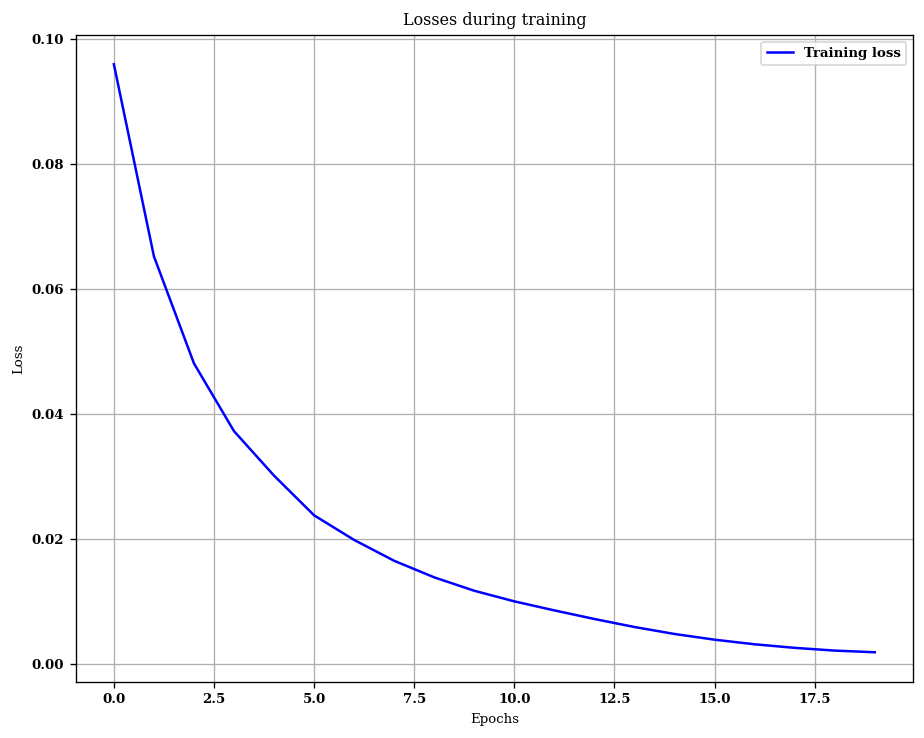

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


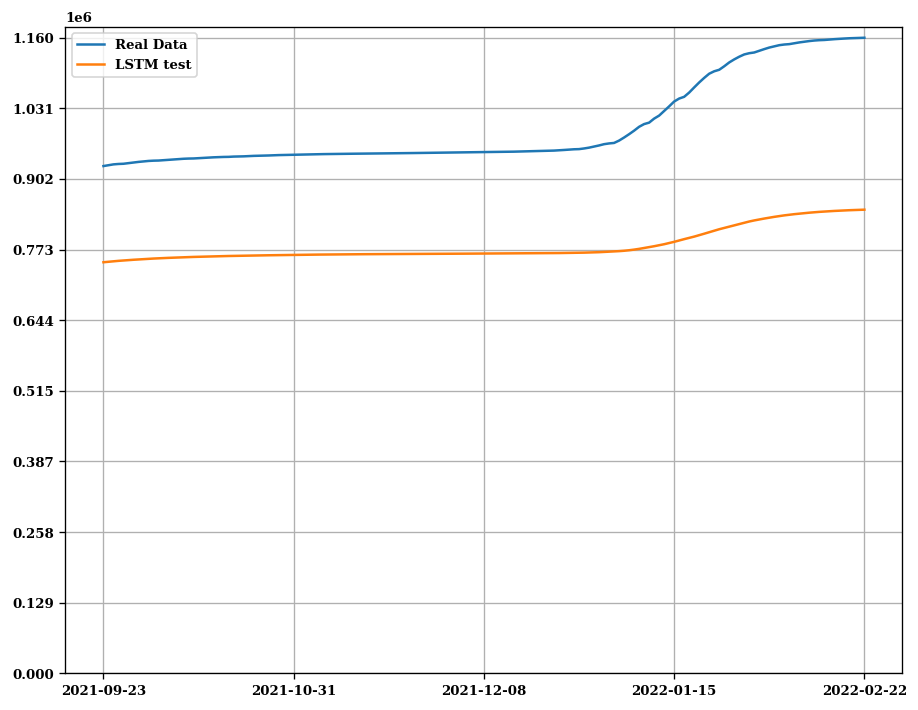

>>> Confirmed Cases LSTM Results MSE = 49519836697.42290 RMSE = 222530.52981 MSLE = 0.06056 RMSLE = 0.24610 MAE = 216470.52206 MAPE = 21.26146
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━

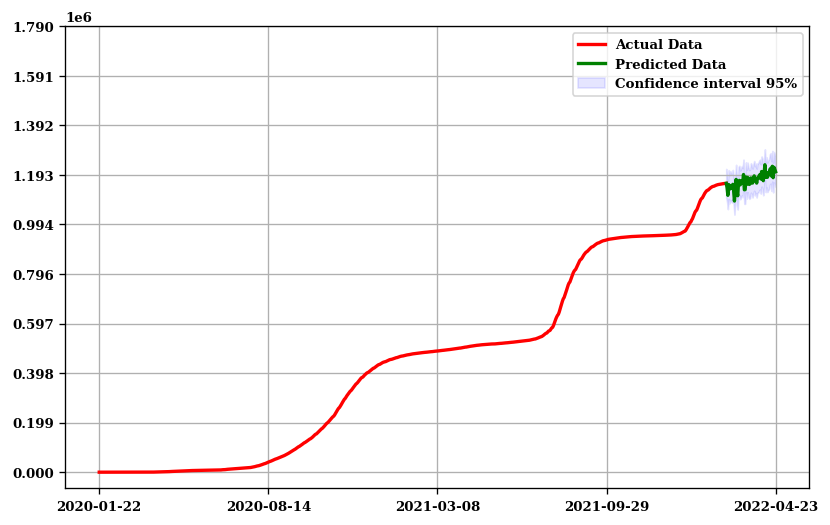

In [29]:
######################################################### Show Results #####################################################################
# Confirmed Cases
# Metrics
res_lstm_ConfirmedCases, mse, rmse, msle, rmsle, mae, mape = evaluate_lstm(forcast_ConfirmedCases,train_rate,lstm_size)
print('>>>', forcast_ConfirmedCases.columns.values[0], 'LSTM Results MSE = %.5f RMSE = %.5f MSLE = %.5f RMSLE = %.5f MAE = %.5f MAPE = %.5f' % (mse, rmse, msle, rmsle, mae, mape))
# Results
res_lstm_ConfirmedCases = show_lstm(forcast_ConfirmedCases, train_rate, lstm_size, days_num, forcast_ConfirmedCases.columns.values[0])
split = len(forcast_ConfirmedCases)
plot2series(res_lstm_ConfirmedCases, split, forcast_ConfirmedCases.columns.values[0]) ## Plot results 

# # Death Cases
# # Metrics
# res_lstm_DeathCases, mse, rmse, msle, rmsle, mae, mape = evaluate_lstm(forcast_DeathCases, train_rate, lstm_size, forcast_DeathCases.columns.values[0])
# print('>>>', forcast_DeathCases.columns.values[0], 'LSTM Results MSE = %.5f RMSE = %.5f MSLE = %.5f RMSLE = %.5f MAE = %.5f MAPE = %.5f' % (mse, rmse, msle, rmsle, mae, mape))
# # Results
# res_lstm_DeathCases = show_lstm(forcast_DeathCases, train_rate, lstm_size, days_num, forcast_DeathCases.columns.values[0])
# plot2series(res_lstm_DeathCases, split, forcast_DeathCases.columns.values[0]) ## Plot results 


In [ ]:
####################################################### Plot R effective #################################################################
####################################################### Plot Rt for ARIMA #################################################################
# # # ARIMA Prepare Data
NewCases_arima_df = prepare_arima_newCases(res_arima_ConfirmedCases, days_num, '2021-02-23')
# # ## ARIMA Plot Rt
original, smoothed = prepare_cases(NewCases_arima_df)
posteriors = get_posteriors(smoothed)
hdis = highest_density_interval(posteriors)
most_likely = posteriors.idxmax().rename('ML')
result = pd.concat([most_likely, hdis], axis=1)
fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_rt(result, ax, country)
ax.set_ylim(0.0,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

In [ ]:
####################################################### Plot Rt for LSTM #################################################################
## LSTM Prepare Data
NewCases_lstm_df = prepare_lstm_newCases(res_lstm_ConfirmedCases, split)
## LSTM Plot Rt
original, smoothed = prepare_cases(NewCases_lstm_df)
posteriors = get_posteriors(smoothed)
hdis = highest_density_interval(posteriors)
most_likely = posteriors.idxmax().rename('ML')
result = pd.concat([most_likely, hdis], axis=1)
fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_rt(result, ax, country)
ax.set_ylim(0.0,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()


In [75]:
######################################################### ARIMA #######################################################################
# Forecasting Confirmed, Recovered and Death Cases in Morocco
country =  'Morocco'  ## you can use any other country name For Example : Brazil, Italy, Spain
# # Confirmed Cases
country_df = confirmed_df[confirmed_df['country'] == country] ## Choose the right columns for the choosing country
country_df = country_df.drop(columns=['country']) ## Drop the columns name, keeping only data
country_df = country_df[:'2022-02-22']
forcast_ConfirmedCases = country_df.copy() ## Copy the data in forcast variable


In [76]:
from pycaret.time_series import TSForecastingExperiment
exp = TSForecastingExperiment()
exp.setup(data = forcast_ConfirmedCases, fh = 3, session_id = 123)
best = exp.compare_models()

,Description,Value
0,session_id,123
1,Target,Confirmed Cases
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(763, 1)"
5,Transformed data shape,"(763, 1)"
6,Transformed train set shape,"(760, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0251,0.0169,271.1565,306.6775,0.0002,0.0002,0.6844,0.8900
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.0251,0.0169,271.1530,306.6730,0.0002,0.0002,0.6844,0.1233
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.0251,0.0168,270.7907,305.6868,0.0002,0.0002,0.6864,0.1133
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.0251,0.0169,271.1565,306.6775,0.0002,0.0002,0.6844,0.6767
auto_arima,Auto ARIMA,0.0324,0.0214,349.9461,388.8266,0.0003,0.0003,0.4926,92.4733
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.0350,0.0224,377.7770,405.9579,0.0003,0.0003,0.3427,0.2700
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.0440,0.0274,474.9175,497.6392,0.0004,0.0004,-0.1828,0.1467
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.0440,0.0274,474.9175,497.6392,0.0004,0.0004,-0.1828,0.7333
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.0558,0.0389,602.1955,706.9421,0.0005,0.0005,-0.5702,0.1367
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.0619,0.0406,668.4061,737.1477,0.0006,0.0006,-0.9490,0.1333


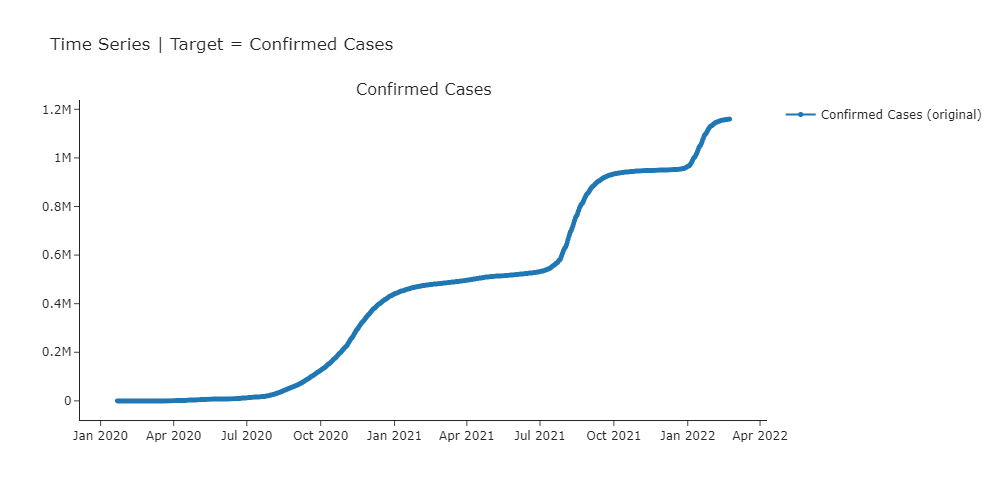

In [85]:
exp.plot_model(plot="ts",fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

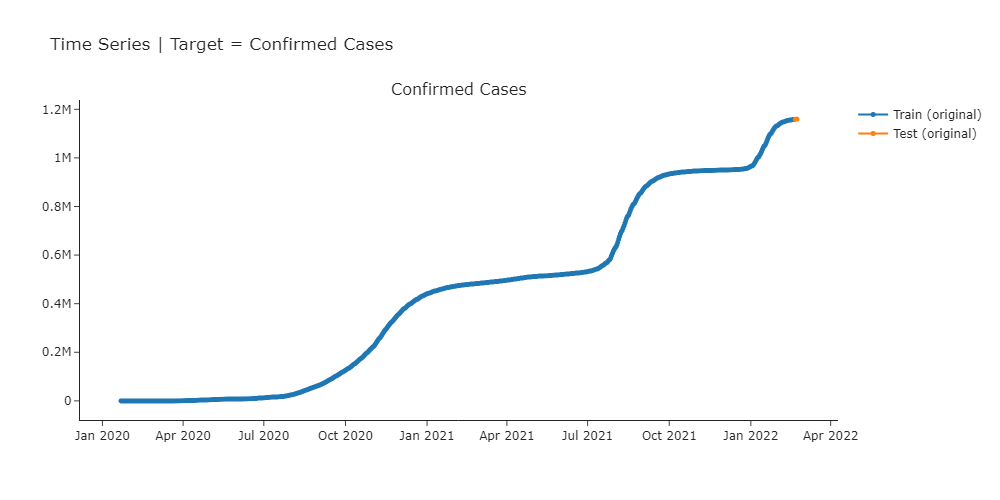

In [86]:
exp.plot_model(plot="train_test_split",fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})


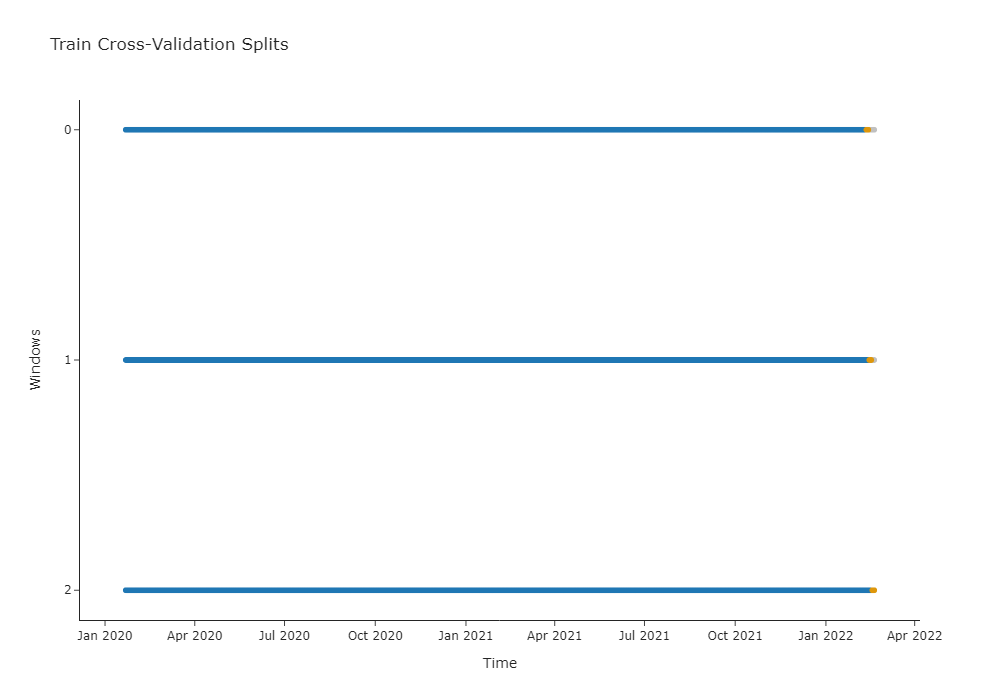

In [87]:
exp.plot_model(plot="cv",fig_kwargs = {"height":700,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [88]:
top4 = exp.compare_models(n_select = 4)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0251,0.0169,271.1565,306.6775,0.0002,0.0002,0.6844,1.1800
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.0251,0.0169,271.1530,306.6730,0.0002,0.0002,0.6844,0.1167
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.0251,0.0168,270.7907,305.6868,0.0002,0.0002,0.6864,0.1333
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.0251,0.0169,271.1565,306.6775,0.0002,0.0002,0.6844,0.6067
auto_arima,Auto ARIMA,0.0324,0.0214,349.9461,388.8266,0.0003,0.0003,0.4926,90.7100
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.0350,0.0224,377.7770,405.9579,0.0003,0.0003,0.3427,0.3000
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.0440,0.0274,474.9175,497.6392,0.0004,0.0004,-0.1828,0.1133
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.0440,0.0274,474.9175,497.6392,0.0004,0.0004,-0.1828,0.8100
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.0558,0.0389,602.1955,706.9421,0.0005,0.0005,-0.5702,0.1733
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.0619,0.0406,668.4061,737.1477,0.0006,0.0006,-0.9490,0.1333


In [89]:
blender = exp.blend_models(top4)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-02-10,0.0470,0.0300,507.3014,545.7634,0.0004,0.0004,0.3145
1,2022-02-13,0.0178,0.0134,192.5810,242.9546,0.0002,0.0002,0.8362
2,2022-02-16,0.0105,0.0072,113.3101,130.5657,0.0001,0.0001,0.9040
Mean,NaT,0.0251,0.0169,271.0642,306.4279,0.0002,0.0002,0.6849
SD,NaT,0.0157,0.0096,170.1509,175.3453,0.0001,0.0001,0.2634


In [90]:
final_model = exp.finalize_model(blender)
pred_holdout = exp.predict_model(final_model)

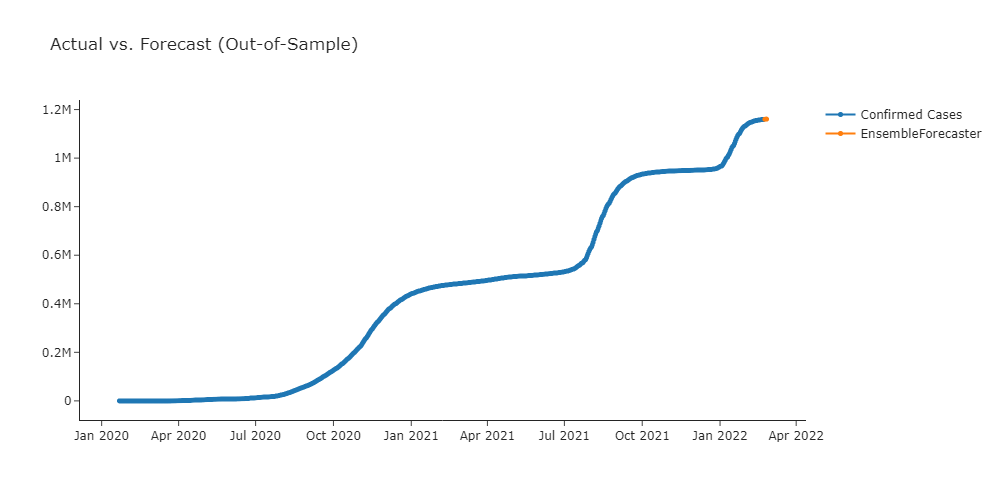

In [91]:
exp.plot_model(final_model,fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})


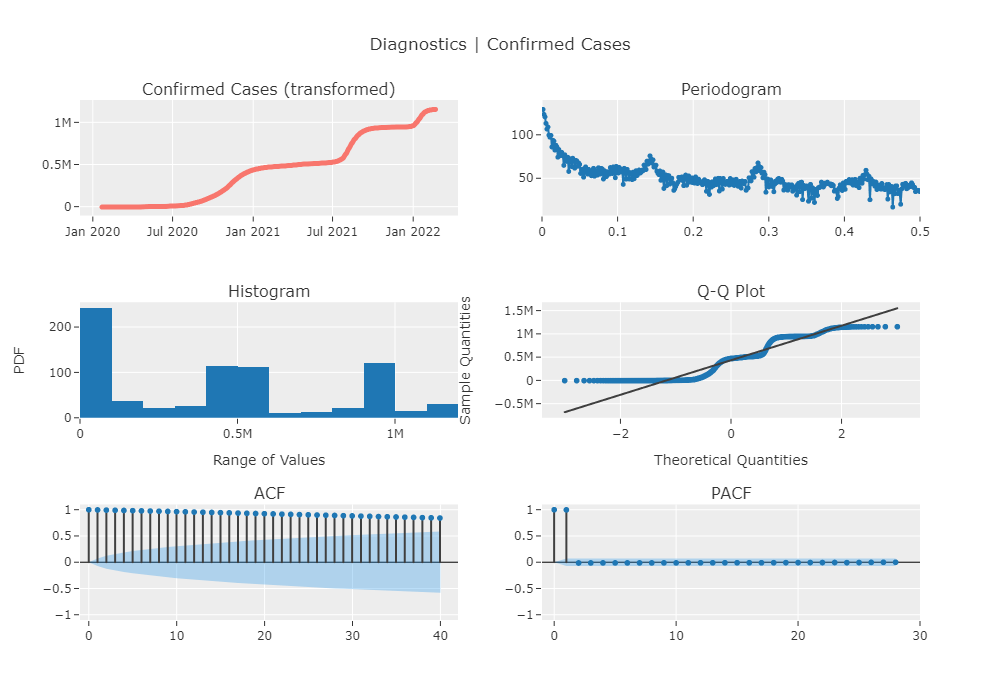

In [92]:
exp.plot_model(plot = 'diagnostics',fig_kwargs = {"height":700,"width":1000,"600": "simple_white","hoverinfo":"none","big_data_threshold":10})